In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import logging
import os
import time
import math
from tqdm import tqdm
from typing import Tuple, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from torch.cuda.amp import autocast, GradScaler

In [7]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [8]:
# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)


In [9]:
class IntrusionDetectionDataset(Dataset):
    """Dataset class for IDS data."""
    
    def __init__(self, X_cnn, X_lstm, y):
        self.X_cnn = torch.FloatTensor(X_cnn)
        self.X_lstm = torch.FloatTensor(X_lstm)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.y)
        
    def __getitem__(self, idx):
        return self.X_cnn[idx], self.X_lstm[idx], self.y[idx]


In [2]:
import torch
import torch.nn as nn

class HybridCNNBiLSTM(nn.Module):
    """
    Improved Hybrid CNN-BiLSTM model with enhanced regularization to combat overfitting.
    """
    def __init__(self, cnn_input_shape, lstm_input_shape, num_classes):
        super(HybridCNNBiLSTM, self).__init__()
        
        # CNN branch with Batch Normalization and Dropout2d for spatial dropout
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # Calculate the flattened CNN output size after two pooling layers
        cnn_output_height = cnn_input_shape[1] // 4  # divided by 2 twice
        cnn_output_width = cnn_input_shape[2] // 4
        self.cnn_output_size = 64 * cnn_output_height * cnn_output_width
        
        # BiLSTM branch with dropout between layers
        self.lstm1 = nn.LSTM(
            input_size=lstm_input_shape[1],
            hidden_size=64,
            batch_first=True,
            bidirectional=True
        )
        # Dropout layer applied on LSTM outputs to prevent overfitting
        self.dropout_lstm = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(
            input_size=128,  # 64 (hidden) * 2 (bidirectional)
            hidden_size=32,
            batch_first=True,
            bidirectional=True
        )
        
        # Combined fully connected layers
        # Note: The BiLSTM output is 32*2 = 64 features (from last time step)
        combined_size = self.cnn_output_size + 64
        self.fc1 = nn.Linear(combined_size, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
        
    def forward(self, x_cnn, x_lstm):
        # CNN branch
        x1 = self.conv1(x_cnn)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.pool1(x1)
        x1 = self.dropout1(x1)
        
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x1 = self.relu(x1)
        x1 = self.pool2(x1)
        x1 = self.dropout2(x1)
        x1 = x1.view(x1.size(0), -1)  # Flatten
        
        # BiLSTM branch
        x2, _ = self.lstm1(x_lstm)
        x2 = self.dropout_lstm(x2)
        x2, _ = self.lstm2(x2)
        x2 = x2[:, -1, :]  # Use the output from the last time step
        
        # Feature fusion and classification
        combined = torch.cat((x1, x2), dim=1)
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x

In [11]:
class IntrusionDetectionSystem:
    def __init__(self, config: Dict[str, Any]):
        """
        Initialize the IDS with configuration parameters.
        
        Args:
            config: Dictionary containing model configuration
        """
        self.config = config
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
    def load_data(self, filepath: str) -> pd.DataFrame:
        """
        Load and perform initial cleaning of the CICIDS2017 dataset.
        
        Args:
            filepath: Path to the CSV file
            
        Returns:
            Cleaned DataFrame
        """
        try:
            logger.info("Loading pre-processed dataset...")
            print("\nReading CSV file...")
            df = pd.read_csv(filepath)
            
            # Log dataset information
            logger.info(f"Loaded {len(df):,} rows and {len(df.columns):,} columns")
            logger.info(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
            
            return df
            
        except Exception as e:
            logger.error(f"Error loading data: {str(e)}")
            raise
            
    def preprocess_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Preprocess the data for training.
        
        Args:
            df: Input DataFrame
            
        Returns:
            Tuple of (features, labels)
        """
        try:
            print("\nPreprocessing data...")
            # Separate features and labels
            X = df.drop(self.config['label_column'], axis=1)
            y = df[self.config['label_column']]
            
            # Scale features
            print("Scaling features...")
            X_scaled = self.scaler.fit_transform(X)
            
            # Encode labels
            print("Encoding labels...")
            y_encoded = self.label_encoder.fit_transform(y)
            
            # Log class distribution
            unique_labels, counts = np.unique(y_encoded, return_counts=True)
            logger.info("\nClass distribution:")
            for label, count in zip(self.label_encoder.classes_, counts):
                logger.info(f"{label}: {count:,} samples")
            
            return X_scaled, y_encoded
            
        except Exception as e:
            logger.error(f"Error preprocessing data: {str(e)}")
            raise

    def reshape_data(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Reshape data for CNN and BiLSTM branches with memory efficiency.
        
        Args:
            X: Input features
            
        Returns:
            Tuple of (CNN_shaped_data, LSTM_shaped_data)
        """
        try:
            print("\nReshaping data for neural networks...")
            
            # Convert to float32 to reduce memory by half
            X = X.astype(np.float32)
            
            # Process in chunks for both CNN and LSTM
            chunk_size = 10000  # Adjust based on your available memory
            num_chunks = (X.shape[0] + chunk_size - 1) // chunk_size
            
            # Calculate dimensions once
            features_sqrt = math.ceil(np.sqrt(X.shape[1]))
            padding_cnn = features_sqrt ** 2 - X.shape[1]
            
            # For LSTM reshaping
            timesteps = self.config['timesteps']
            if X.shape[1] % timesteps != 0:
                new_total = math.ceil(X.shape[1] / timesteps) * timesteps
                padding_lstm = new_total - X.shape[1]
            else:
                new_total = X.shape[1]
                padding_lstm = 0
                
            # Pre-allocate output arrays
            X_cnn_shape = (X.shape[0], 1, features_sqrt, features_sqrt)
            X_lstm_shape = (X.shape[0], timesteps, new_total // timesteps)
            
            X_cnn = np.zeros(X_cnn_shape, dtype=np.float32)
            X_lstm = np.zeros(X_lstm_shape, dtype=np.float32)
            
            # Process in chunks
            for i in range(num_chunks):
                start_idx = i * chunk_size
                end_idx = min((i + 1) * chunk_size, X.shape[0])
                chunk = X[start_idx:end_idx]
                
                # CNN reshaping for this chunk
                if padding_cnn > 0:
                    chunk_padded_cnn = np.pad(chunk, ((0, 0), (0, padding_cnn)), mode='constant')
                else:
                    chunk_padded_cnn = chunk.copy()
                    
                X_cnn[start_idx:end_idx] = chunk_padded_cnn.reshape(-1, 1, features_sqrt, features_sqrt)
                
                # LSTM reshaping for this chunk
                if padding_lstm > 0:
                    chunk_padded_lstm = np.pad(chunk, ((0, 0), (0, padding_lstm)), mode='constant')
                else:
                    chunk_padded_lstm = chunk.copy()
                    
                X_lstm[start_idx:end_idx] = chunk_padded_lstm.reshape(-1, timesteps, new_total // timesteps)
                
                # Force garbage collection after each chunk
                del chunk, chunk_padded_cnn, chunk_padded_lstm
                if i % 10 == 0:  # Every 10 chunks
                    import gc
                    gc.collect()
                    print(f"Processed chunk {i+1}/{num_chunks}")
            
            return X_cnn, X_lstm
                
        except Exception as e:
            logger.error(f"Error reshaping data: {str(e)}")
            raise        
    
            
    def handle_class_imbalance(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Handle class imbalance using Focal Loss preparation.
        This approach computes class weights for Focal Loss instead of using SMOTE.
        
        Args:
            X: Features
            y: Labels
            
        Returns:
            Tuple of (original_features, original_labels)
        """
        try:
            print("\nHandling class imbalance...")
            start_time = time.time()
            
            logger.info("Class distribution:")
            unique_labels, counts = np.unique(y, return_counts=True)
            for label, count in zip(unique_labels, counts):
                logger.info(f"Class {label}: {count:,} samples")
            
            # Calculate class weights for Focal Loss
            total_samples = len(y)
            n_classes = len(unique_labels)
            class_weights = {}
            
            # Calculate inverse frequency weights
            for label, count in zip(unique_labels, counts):
                # Class weight is inversely proportional to frequency
                weight = total_samples / (n_classes * count)
                # Store to be used in the model training
                class_weights[int(label)] = weight
                logger.info(f"Class {label} weight: {weight:.4f}")
            
            # Store class weights as an attribute to be used during training
            self.class_weights = class_weights
            
            duration = time.time() - start_time
            logger.info(f"Class weight calculation completed in {duration:.2f} seconds")
            
            # Return original data - no resampling needed with Focal Loss
            return X, y
                
        except Exception as e:
            logger.error(f"Error handling class imbalance: {str(e)}")
            raise
    
    def create_dataloaders(self, X_train_cnn, X_train_lstm, y_train, 
                      X_val_cnn, X_val_lstm, y_val,
                      X_test_cnn, X_test_lstm, y_test):
        """
        Create PyTorch DataLoaders for training, validation and testing.
        
        Returns:
            Tuple of (train_loader, val_loader, test_loader)
        """
        try:
            print("\nCreating PyTorch DataLoaders...")
            
            # Create datasets
            train_dataset = IntrusionDetectionDataset(X_train_cnn, X_train_lstm, y_train)
            val_dataset = IntrusionDetectionDataset(X_val_cnn, X_val_lstm, y_val)
            test_dataset = IntrusionDetectionDataset(X_test_cnn, X_test_lstm, y_test)
            
            # Get system-specific settings
            import platform
            is_windows = platform.system() == 'Windows'
            
            # On Windows, multiprocessing needs to use 'spawn' method
            if is_windows:
                import torch.multiprocessing as mp
                mp.set_start_method('spawn', force=True)
            
            # Determine safe num_workers based on system
            if is_windows:
                # On Windows, num_workers often causes issues, use 0 for safety
                # or set to 1 for minimal parallelism
                safe_workers = 0
            else:
                # On Unix systems, we can use the configured value
                safe_workers = self.config.get('num_workers', 0)
            
            print(f"Using {safe_workers} DataLoader workers (adjusted for platform compatibility)")
            
            # Create dataloaders using config parameters with platform-specific adjustments
            train_loader = DataLoader(
                train_dataset, 
                batch_size=self.config.get('batch_size', 32),
                shuffle=True,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,  # Keep workers alive between iterations if using workers
                prefetch_factor=2 if safe_workers > 0 else None,  # Prefetch 2 batches per worker
            )
            
            val_loader = DataLoader(
                val_dataset, 
                batch_size=self.config.get('batch_size', 32), 
                shuffle=False,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,
                prefetch_factor=2 if safe_workers > 0 else None,
            )
            
            test_loader = DataLoader(
                test_dataset, 
                batch_size=self.config.get('batch_size', 32), 
                shuffle=False,
                num_workers=safe_workers,
                pin_memory=self.config.get('pin_memory', True),
                persistent_workers=safe_workers > 0,
                prefetch_factor=2 if safe_workers > 0 else None,
            )
            
            logger.info(f"Created DataLoaders with {len(train_loader)} training batches, "
                    f"{len(val_loader)} validation batches, and {len(test_loader)} test batches")
            
            return train_loader, val_loader, test_loader
            
        except Exception as e:
            logger.error(f"Error creating DataLoaders: {str(e)}")
            raise
    #insert here        
    def train_and_evaluate(self, train_loader, val_loader, test_loader, cnn_input_shape, lstm_input_shape, num_classes):
        """Train the model and evaluate its performance using Automatic Mixed Precision."""
        try:
            print("\nStarting model training with Automatic Mixed Precision...")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            # Initialize model
            model = HybridCNNBiLSTM(cnn_input_shape, lstm_input_shape, num_classes).to(device)
            
            # Set up optimizer and scheduler with gradient accumulation
            optimizer = optim.Adam(model.parameters(), lr=self.config['learning_rate'], weight_decay=1e-4)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

            # Replacing standard CrossEntropyLoss with weighted version
            class_weights = torch.FloatTensor([self.class_weights[i] for i in range(len(self.class_weights))]).to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            
            # Check if mixed precision should be used (based on config and availability)
            use_amp = self.config.get('mixed_precision', False) and torch.cuda.is_available()
            
            # Initialize the scaler for AMP if needed
            if use_amp:
                print("Using Automatic Mixed Precision (AMP) for training")
                # Use the updated import pattern for autocast to avoid deprecation warning
                from torch.amp import autocast
                scaler = torch.cuda.amp.GradScaler()
            else:
                print("Using full precision for training")
                scaler = None
            
            # Validate dataset before training
            print("Validating dataset for correct class indices...")
            try:
                for batch_idx, (x_cnn, x_lstm, targets) in enumerate(train_loader):
                    min_target = targets.min().item()
                    max_target = targets.max().item()
                    if min_target < 0 or max_target >= num_classes:
                        raise ValueError(f"Invalid targets in batch {batch_idx}: range [{min_target}, {max_target}], "
                                        f"should be [0, {num_classes-1}]")
                    
                    # Only check a few batches to save time
                    if batch_idx >= 5:
                        break
                print("Dataset validation complete - no invalid class indices found")
            except Exception as e:
                logger.error(f"Dataset validation error: {str(e)}")
                raise
            
            # Training loop with memory management
            history = []
            best_val_loss = float('inf')
            accumulation_steps = 8  # Accumulate gradients over multiple batches
            
            for epoch in range(self.config['epochs']):
                # Training
                model.train()
                train_loss = 0.0
                train_correct = 0
                train_total = 0
                
                progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), 
                                desc=f"Epoch {epoch+1}/{self.config['epochs']}")
                
                optimizer.zero_grad()  # Reset gradients at the start of each epoch
                
                for batch_idx, (x_cnn, x_lstm, targets) in progress_bar:
                    try:
                        # Sanity check for targets
                        if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                            problematic_indices = torch.where((targets >= num_classes) | (targets < 0))[0]
                            logger.error(f"Invalid target values in batch {batch_idx}, indices: {problematic_indices.tolist()}")
                            # Skip this batch and continue with next
                            continue
                        
                        # Move to device
                        x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                        
                        # Forward pass with or without mixed precision
                        if use_amp:
                            with autocast(device_type='cuda'):
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                        else:
                            outputs = model(x_cnn, x_lstm)
                            loss = criterion(outputs, targets)
                        
                        # Safeguard against NaN or Inf loss
                        if not torch.isfinite(loss):
                            logger.error(f"Non-finite loss detected in batch {batch_idx}: {loss.item()}")
                            continue
                        
                        # Normalize loss to account for accumulation
                        normalized_loss = loss / accumulation_steps
                        
                        # Backward pass with or without scaled gradients
                        if use_amp:
                            scaler.scale(normalized_loss).backward()
                        else:
                            normalized_loss.backward()
                        
                        # Only update weights after accumulation_steps
                        if (batch_idx + 1) % accumulation_steps == 0 or batch_idx + 1 == len(train_loader):
                            if use_amp:
                                # Unscales the gradients
                                scaler.unscale_(optimizer)
                                
                                # Optional: gradient clipping to prevent exploding gradients
                                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                
                                # Updates parameters and resets gradients
                                scaler.step(optimizer)
                                scaler.update()
                            else:
                                # Regular optimization step
                                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                                optimizer.step()
                                
                            optimizer.zero_grad()
                        
                        # Update metrics (use the original loss value for metrics)
                        train_loss += loss.item()
                        _, predicted = outputs.max(1)
                        train_total += targets.size(0)
                        train_correct += predicted.eq(targets).sum().item()
                        
                        # Update progress bar
                        progress_bar.set_postfix({
                            'loss': train_loss / (batch_idx + 1), 
                            'acc': 100. * train_correct / train_total
                        })
                        
                        # Clear cache periodically
                        if batch_idx % 100 == 0:
                            torch.cuda.empty_cache() if torch.cuda.is_available() else None
                            
                    except Exception as e:
                        logger.error(f"Error in batch {batch_idx}: {str(e)}")
                        # Print shapes safely
                        logger.error(f"Input shapes - CNN: {x_cnn.shape}, LSTM: {x_lstm.shape}, Targets: {targets.shape}")
                        # Move to CPU before logging tensor values
                        try:
                            targets_cpu = targets.detach().cpu().numpy()
                            logger.error(f"Target unique values: {np.unique(targets_cpu)}")
                        except:
                            logger.error("Could not convert targets to CPU")
                        # Continue with next batch instead of stopping completely
                        continue
                
                # Validation phase
                model.eval()
                val_loss = 0.0
                val_correct = 0
                val_total = 0
                
                with torch.no_grad():
                    for batch_idx, (x_cnn, x_lstm, targets) in enumerate(val_loader):
                        try:
                            # Sanity check for targets
                            if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                                logger.error(f"Invalid validation target values in batch {batch_idx}")
                                continue
                                
                            # Move to device
                            x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                            
                            # Forward pass (consistent evaluation, with or without autocast)
                            if use_amp:
                                with autocast(device_type='cuda'):
                                    outputs = model(x_cnn, x_lstm)
                                    loss = criterion(outputs, targets)
                            else:
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                            
                            # Update metrics
                            val_loss += loss.item()
                            _, predicted = outputs.max(1)
                            val_total += targets.size(0)
                            val_correct += predicted.eq(targets).sum().item()
                        except Exception as e:
                            logger.error(f"Error in validation batch {batch_idx}: {str(e)}")
                            continue
                
                # Calculate metrics
                epoch_train_loss = train_loss / len(train_loader)
                epoch_train_acc = 100. * train_correct / train_total if train_total > 0 else 0
                epoch_val_loss = val_loss / len(val_loader)
                epoch_val_acc = 100. * val_correct / val_total if val_total > 0 else 0
                
                # Update learning rate based on validation loss
                scheduler.step(epoch_val_loss)
                
                # Print metrics
                print(f"Epoch {epoch+1}/{self.config['epochs']} - "
                    f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
                    f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")
                
                # Save metrics
                history.append({
                    'epoch': epoch + 1,
                    'train_loss': epoch_train_loss,
                    'train_acc': epoch_train_acc,
                    'val_loss': epoch_val_loss,
                    'val_acc': epoch_val_acc
                })
                
                # Save best model
                if epoch_val_loss < best_val_loss:
                    best_val_loss = epoch_val_loss
                    torch.save(model.state_dict(), 'best_model.pth')
                    print(f"Model saved with validation loss: {best_val_loss:.4f}")
                    
                # Early stopping
                if len(history) > 5:
                    recent_val_losses = [h['val_loss'] for h in history[-5:]]
                    if all(recent_val_losses[i] > recent_val_losses[i-1] for i in range(1, len(recent_val_losses))):
                        print("Early stopping due to increasing validation loss")
                        break
            
            # Test the model on test set
            model.load_state_dict(torch.load('best_model.pth'))
            model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            all_predictions = []
            all_targets = []
            
            with torch.no_grad():
                for batch_idx, (x_cnn, x_lstm, targets) in enumerate(test_loader):
                    try:
                        # Sanity check for targets
                        if torch.max(targets).item() >= num_classes or torch.min(targets).item() < 0:
                            logger.error(f"Invalid test target values in batch {batch_idx}")
                            continue
                            
                        x_cnn, x_lstm, targets = x_cnn.to(device), x_lstm.to(device), targets.to(device)
                        
                        # Consistent evaluation approach
                        if use_amp:
                            with autocast(device_type='cuda'):
                                outputs = model(x_cnn, x_lstm)
                                loss = criterion(outputs, targets)
                        else:
                            outputs = model(x_cnn, x_lstm)
                            loss = criterion(outputs, targets)
                        
                        test_loss += loss.item()
                        _, predicted = outputs.max(1)
                        test_total += targets.size(0)
                        test_correct += predicted.eq(targets).sum().item()
                        
                        all_predictions.extend(predicted.cpu().numpy())
                        all_targets.extend(targets.cpu().numpy())
                    except Exception as e:
                        logger.error(f"Error in testing batch {batch_idx}: {str(e)}")
                        continue
            
            test_loss = test_loss / len(test_loader) if len(test_loader) > 0 else float('inf')
            test_acc = 100. * test_correct / test_total if test_total > 0 else 0
            
            print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
            
            return model, history
        
        except Exception as e:
            logger.error(f"Error during training and evaluation: {str(e)}")
            # Print current stack trace for more detailed debugging
            import traceback
            logger.error(f"Stack trace: {traceback.format_exc()}")
            raise
        
    def _plot_training_history(self, history):
        """Plot and save training history metrics."""
        try:
            # Create figure with 2 subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
            
            # Plot losses
            ax1.plot(history['train_loss'], label='Training Loss')
            ax1.plot(history['val_loss'], label='Validation Loss')
            ax1.set_title('Loss Over Epochs')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True)
            
            # Plot accuracies
            ax2.plot(history['train_acc'], label='Training Accuracy')
            ax2.plot(history['val_acc'], label='Validation Accuracy')
            ax2.set_title('Accuracy Over Epochs')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy (%)')
            ax2.legend()
            ax2.grid(True)
            
            plt.tight_layout()
            plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
            logger.info("Training history plot saved to 'training_history.png'")
            
        except Exception as e:
            logger.error(f"Error plotting training history: {str(e)}")
            
    def save_model(self, model, path="ids_model.pth"):
        """Save the PyTorch model."""
        try:
            # Save model state dict
            torch.save({
                'model_state_dict': model.state_dict(),
                'scaler': self.scaler,
                'label_encoder': self.label_encoder,
                'config': self.config
            }, path)
            
            logger.info(f"Model saved successfully to '{path}'")
            
        except Exception as e:
            logger.error(f"Error saving model: {str(e)}")
            raise

In [4]:
def main():
    """Main function to run the IDS pipeline."""
    # Configuration
    config = {
        'data_path': "data/raw/cicids2017_cleaned.csv",
        'label_column': 'Attack Type',
        'test_size': 0.2,
        'val_size': 0.2,  # Validation set size (from training data)
        'random_state': 42,
        'timesteps': 10,
        'epochs': 50,
        'batch_size': 128,
        'learning_rate': 0.001,
        'patience': 5,
        'num_workers': 8, # Number of workers for data loading
        'mixed_precision': True,  # Use mixed precision training
        'pin_memory': True,  # Pin memory for faster GPU transfer
    }
    
    try:
        print("\n=== Starting Intrusion Detection System Training ===")
        start_time = time.time()
        
        # Initialize IDS
        ids = IntrusionDetectionSystem(config)
        
        # Load and preprocess data
        df = ids.load_data(config['data_path'])
        X, y = ids.preprocess_data(df)
        
        # Handle class imbalance
        print("\nChecking class distribution...")
        unique_labels, counts = np.unique(y, return_counts=True)
        imbalanced = max(counts) / min(counts) > 10  # Check if imbalance ratio > 10

        if imbalanced:
            print("Detected significant class imbalance. Applying SMOTE...")
            X_balanced, y_balanced = ids.handle_class_imbalance(X, y)
        else:
            print("Class distribution is acceptable. Proceeding without balancing.")
            X_balanced, y_balanced = X, y
        
        # Split data into train and test sets
        print("\nSplitting data into training and test sets...")
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X_balanced, y_balanced,
            test_size=config['test_size'],
            random_state=config['random_state'],
            stratify=y_balanced  # Ensure balanced split
        )
        
        # Further split train data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full,
            test_size=config['val_size'],
            random_state=config['random_state'],
            stratify=y_train_full
        )
        # Convert features to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        X_test = X_test.astype(np.float32)

        # Convert targets to int64
        y_train = y_train.astype(np.int64)
        y_val = y_val.astype(np.int64)
        y_test = y_test.astype(np.int64)
        
        logger.info(f"Training set size: {len(X_train):,} samples")
        logger.info(f"Validation set size: {len(X_val):,} samples")
        logger.info(f"Test set size: {len(X_test):,} samples")
        
        # Reshape data for both branches
        X_train_cnn, X_train_lstm = ids.reshape_data(X_train)
        X_val_cnn, X_val_lstm = ids.reshape_data(X_val)
        X_test_cnn, X_test_lstm = ids.reshape_data(X_test)
        print("X_train_lstm shape:", X_train_lstm.shape)
        print("lstm_input_shape:", X_train_lstm.shape[1:])
        # Create dataloaders
        train_loader, val_loader, test_loader = ids.create_dataloaders(
            X_train_cnn, X_train_lstm, y_train,
            X_val_cnn, X_val_lstm, y_val,
            X_test_cnn, X_test_lstm, y_test
        )
        
        # Train and evaluate model
        model, history = ids.train_and_evaluate(
            train_loader, 
            val_loader, 
            test_loader,
            cnn_input_shape=X_train_cnn.shape[1:],
            lstm_input_shape=X_train_lstm.shape[1:],
            num_classes= len(np.unique(y))
        )
        
        # Save model
        ids.save_model(model, path='ids_model.pth')
        
        total_duration = time.time() - start_time
        logger.info(f"\nTotal execution time: {total_duration:.2f} seconds")
        print("\n=== Training Complete ===")
        
    except Exception as e:
        logger.error(f"Error in main function: {str(e)}")
        raise

if __name__ == "__main__":
    main()



=== Starting Intrusion Detection System Training ===


NameError: name 'logger' is not defined

Training history plot saved to 'training_history.png'


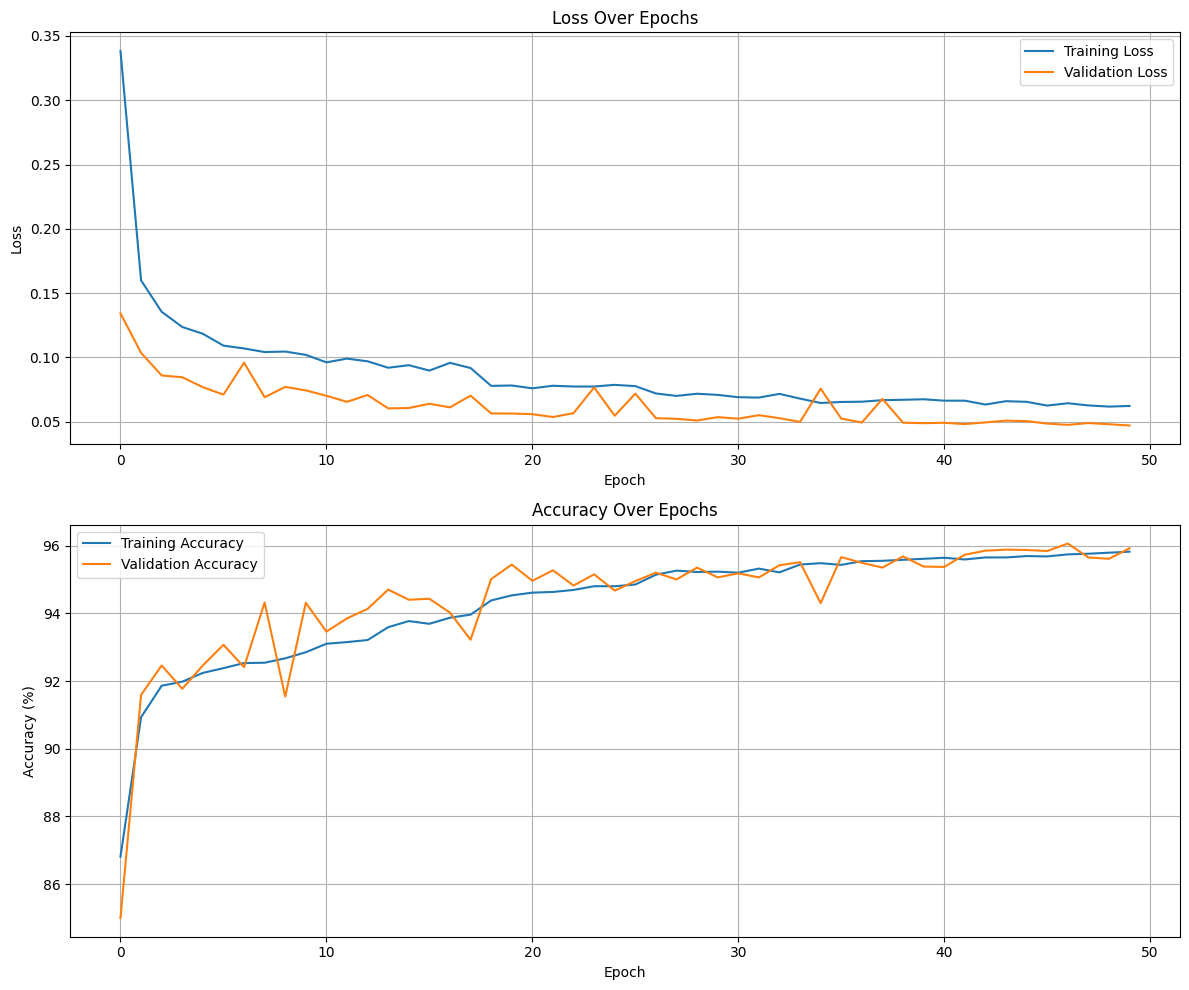

Final training accuracy: 95.82%
Final validation accuracy: 95.92%
Test accuracy: 95.96%


In [16]:
import matplotlib.pyplot as plt
import re
import numpy as np

# Extract metrics from log content
def extract_metrics_from_logs(log_content):
    # Regular expression to extract metrics for each epoch
    pattern = r"Epoch (\d+)/\d+ - Train Loss: ([\d\.]+), Train Acc: ([\d\.]+)%, Val Loss: ([\d\.]+), Val Acc: ([\d\.]+)%"
    matches = re.findall(pattern, log_content)
    
    # Create history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for match in matches:
        epoch, train_loss, train_acc, val_loss, val_acc = match
        history['train_loss'].append(float(train_loss))
        history['train_acc'].append(float(train_acc))
        history['val_loss'].append(float(val_loss))
        history['val_acc'].append(float(val_acc))
    
    return history

# Your log content as a string
log_content = """
Epoch 1/50: 100%|██████████| 12604/12604 [01:49<00:00, 115.56it/s, loss=0.338, acc=86.8]
Epoch 1/50 - Train Loss: 0.3382, Train Acc: 86.81%, Val Loss: 0.1343, Val Acc: 85.00%
Model saved with validation loss: 0.1343
Epoch 2/50: 100%|██████████| 12604/12604 [02:11<00:00, 95.50it/s, loss=0.16, acc=90.9]  
Epoch 2/50 - Train Loss: 0.1599, Train Acc: 90.93%, Val Loss: 0.1036, Val Acc: 91.59%
Model saved with validation loss: 0.1036
Epoch 3/50: 100%|██████████| 12604/12604 [01:58<00:00, 106.23it/s, loss=0.135, acc=91.9]
Epoch 3/50 - Train Loss: 0.1355, Train Acc: 91.86%, Val Loss: 0.0860, Val Acc: 92.46%
Model saved with validation loss: 0.0860
Epoch 4/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.27it/s, loss=0.124, acc=92] 
Epoch 4/50 - Train Loss: 0.1237, Train Acc: 91.98%, Val Loss: 0.0846, Val Acc: 91.77%
Model saved with validation loss: 0.0846
Epoch 5/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.01it/s, loss=0.118, acc=92.2]
Epoch 5/50 - Train Loss: 0.1184, Train Acc: 92.24%, Val Loss: 0.0769, Val Acc: 92.46%
Model saved with validation loss: 0.0769
Epoch 6/50: 100%|██████████| 12604/12604 [01:48<00:00, 116.61it/s, loss=0.109, acc=92.4]
Epoch 6/50 - Train Loss: 0.1092, Train Acc: 92.38%, Val Loss: 0.0711, Val Acc: 93.07%
Model saved with validation loss: 0.0711
Epoch 7/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.93it/s, loss=0.107, acc=92.5]
Epoch 7/50 - Train Loss: 0.1070, Train Acc: 92.53%, Val Loss: 0.0959, Val Acc: 92.41%
Epoch 8/50: 100%|██████████| 12604/12604 [01:44<00:00, 120.52it/s, loss=0.104, acc=92.5]
Epoch 8/50 - Train Loss: 0.1042, Train Acc: 92.54%, Val Loss: 0.0691, Val Acc: 94.32%
Model saved with validation loss: 0.0691
Epoch 9/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.51it/s, loss=0.105, acc=92.7]
Epoch 9/50 - Train Loss: 0.1046, Train Acc: 92.67%, Val Loss: 0.0771, Val Acc: 91.54%
Epoch 10/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.73it/s, loss=0.102, acc=92.9]
Epoch 10/50 - Train Loss: 0.1020, Train Acc: 92.85%, Val Loss: 0.0744, Val Acc: 94.31%
Epoch 11/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.98it/s, loss=0.0962, acc=93.1]
Epoch 11/50 - Train Loss: 0.0962, Train Acc: 93.10%, Val Loss: 0.0702, Val Acc: 93.46%
Epoch 12/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.12it/s, loss=0.0991, acc=93.1]
Epoch 12/50 - Train Loss: 0.0991, Train Acc: 93.15%, Val Loss: 0.0655, Val Acc: 93.85%
Model saved with validation loss: 0.0655
Epoch 13/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.44it/s, loss=0.097, acc=93.2] 
Epoch 13/50 - Train Loss: 0.0970, Train Acc: 93.21%, Val Loss: 0.0708, Val Acc: 94.13%
Epoch 14/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.90it/s, loss=0.092, acc=93.6] 
Epoch 14/50 - Train Loss: 0.0920, Train Acc: 93.59%, Val Loss: 0.0604, Val Acc: 94.70%
Model saved with validation loss: 0.0604
Epoch 15/50: 100%|██████████| 12604/12604 [01:47<00:00, 116.95it/s, loss=0.094, acc=93.8] 
Epoch 15/50 - Train Loss: 0.0940, Train Acc: 93.77%, Val Loss: 0.0607, Val Acc: 94.40%
Epoch 16/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.56it/s, loss=0.0898, acc=93.7]
Epoch 16/50 - Train Loss: 0.0898, Train Acc: 93.69%, Val Loss: 0.0640, Val Acc: 94.43%
Epoch 17/50: 100%|██████████| 12604/12604 [01:43<00:00, 121.23it/s, loss=0.0958, acc=93.9]
Epoch 17/50 - Train Loss: 0.0958, Train Acc: 93.87%, Val Loss: 0.0612, Val Acc: 94.02%
Epoch 18/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.91it/s, loss=0.0918, acc=94] 
Epoch 18/50 - Train Loss: 0.0918, Train Acc: 93.96%, Val Loss: 0.0703, Val Acc: 93.22%
Epoch 19/50: 100%|██████████| 12604/12604 [01:45<00:00, 118.96it/s, loss=0.0779, acc=94.4]
Epoch 19/50 - Train Loss: 0.0779, Train Acc: 94.38%, Val Loss: 0.0565, Val Acc: 95.01%
Model saved with validation loss: 0.0565
Epoch 20/50: 100%|██████████| 12604/12604 [01:44<00:00, 120.15it/s, loss=0.0782, acc=94.5]
Epoch 20/50 - Train Loss: 0.0782, Train Acc: 94.53%, Val Loss: 0.0564, Val Acc: 95.44%
Model saved with validation loss: 0.0564
Epoch 21/50: 100%|██████████| 12604/12604 [01:44<00:00, 120.97it/s, loss=0.076, acc=94.6] 
Epoch 21/50 - Train Loss: 0.0760, Train Acc: 94.61%, Val Loss: 0.0559, Val Acc: 94.96%
Model saved with validation loss: 0.0559
Epoch 22/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.74it/s, loss=0.078, acc=94.6] 
Epoch 22/50 - Train Loss: 0.0780, Train Acc: 94.63%, Val Loss: 0.0537, Val Acc: 95.27%
Model saved with validation loss: 0.0537
Epoch 23/50: 100%|██████████| 12604/12604 [01:44<00:00, 120.82it/s, loss=0.0774, acc=94.7]
Epoch 23/50 - Train Loss: 0.0774, Train Acc: 94.69%, Val Loss: 0.0567, Val Acc: 94.82%
Epoch 24/50: 100%|██████████| 12604/12604 [01:44<00:00, 121.04it/s, loss=0.0774, acc=94.8]
Epoch 24/50 - Train Loss: 0.0774, Train Acc: 94.80%, Val Loss: 0.0767, Val Acc: 95.15%
Epoch 25/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.18it/s, loss=0.0787, acc=94.8]
Epoch 25/50 - Train Loss: 0.0787, Train Acc: 94.80%, Val Loss: 0.0547, Val Acc: 94.67%
Epoch 26/50: 100%|██████████| 12604/12604 [01:43<00:00, 122.15it/s, loss=0.0777, acc=94.8]
Epoch 26/50 - Train Loss: 0.0777, Train Acc: 94.85%, Val Loss: 0.0719, Val Acc: 94.95%
Epoch 27/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.16it/s, loss=0.072, acc=95.1] 
Epoch 27/50 - Train Loss: 0.0720, Train Acc: 95.14%, Val Loss: 0.0528, Val Acc: 95.20%
Model saved with validation loss: 0.0528
Epoch 28/50: 100%|██████████| 12604/12604 [01:45<00:00, 118.97it/s, loss=0.0701, acc=95.3]
Epoch 28/50 - Train Loss: 0.0701, Train Acc: 95.26%, Val Loss: 0.0523, Val Acc: 95.00%
Model saved with validation loss: 0.0523
Epoch 29/50: 100%|██████████| 12604/12604 [01:43<00:00, 122.06it/s, loss=0.0718, acc=95.2]
Epoch 29/50 - Train Loss: 0.0718, Train Acc: 95.22%, Val Loss: 0.0510, Val Acc: 95.35%
Model saved with validation loss: 0.0510
Epoch 30/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.81it/s, loss=0.0709, acc=95.2]
Epoch 30/50 - Train Loss: 0.0709, Train Acc: 95.23%, Val Loss: 0.0536, Val Acc: 95.06%
Epoch 31/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.40it/s, loss=0.0691, acc=95.2]
Epoch 31/50 - Train Loss: 0.0691, Train Acc: 95.20%, Val Loss: 0.0524, Val Acc: 95.18%
Epoch 32/50: 100%|██████████| 12604/12604 [01:44<00:00, 121.07it/s, loss=0.0688, acc=95.3]
Epoch 32/50 - Train Loss: 0.0688, Train Acc: 95.32%, Val Loss: 0.0551, Val Acc: 95.06%
Epoch 33/50: 100%|██████████| 12604/12604 [01:44<00:00, 120.96it/s, loss=0.0717, acc=95.2]
Epoch 33/50 - Train Loss: 0.0717, Train Acc: 95.21%, Val Loss: 0.0528, Val Acc: 95.42%
Epoch 34/50: 100%|██████████| 12604/12604 [01:46<00:00, 118.43it/s, loss=0.068, acc=95.4] 
Epoch 34/50 - Train Loss: 0.0680, Train Acc: 95.44%, Val Loss: 0.0499, Val Acc: 95.51%
Model saved with validation loss: 0.0499
Epoch 35/50: 100%|██████████| 12604/12604 [01:44<00:00, 120.30it/s, loss=0.0646, acc=95.5]
Epoch 35/50 - Train Loss: 0.0646, Train Acc: 95.48%, Val Loss: 0.0757, Val Acc: 94.30%
Epoch 36/50: 100%|██████████| 12604/12604 [01:43<00:00, 121.55it/s, loss=0.0654, acc=95.4]
Epoch 36/50 - Train Loss: 0.0654, Train Acc: 95.43%, Val Loss: 0.0525, Val Acc: 95.66%
Epoch 37/50: 100%|██████████| 12604/12604 [01:45<00:00, 118.99it/s, loss=0.0656, acc=95.5]
Epoch 37/50 - Train Loss: 0.0656, Train Acc: 95.54%, Val Loss: 0.0494, Val Acc: 95.49%
Model saved with validation loss: 0.0494
Epoch 38/50: 100%|██████████| 12604/12604 [01:48<00:00, 115.74it/s, loss=0.0668, acc=95.6]
Epoch 38/50 - Train Loss: 0.0668, Train Acc: 95.55%, Val Loss: 0.0678, Val Acc: 95.35%
Epoch 39/50: 100%|██████████| 12604/12604 [02:04<00:00, 100.96it/s, loss=0.0671, acc=95.6]
Epoch 39/50 - Train Loss: 0.0671, Train Acc: 95.58%, Val Loss: 0.0493, Val Acc: 95.68%
Model saved with validation loss: 0.0493
Epoch 40/50: 100%|██████████| 12604/12604 [02:06<00:00, 99.86it/s, loss=0.0675, acc=95.6] 
Epoch 40/50 - Train Loss: 0.0675, Train Acc: 95.61%, Val Loss: 0.0489, Val Acc: 95.38%
Model saved with validation loss: 0.0489
Epoch 41/50: 100%|██████████| 12604/12604 [02:08<00:00, 98.39it/s, loss=0.0664, acc=95.6] 
Epoch 41/50 - Train Loss: 0.0664, Train Acc: 95.64%, Val Loss: 0.0492, Val Acc: 95.37%
Epoch 42/50: 100%|██████████| 12604/12604 [02:09<00:00, 97.48it/s, loss=0.0664, acc=95.6] 
Epoch 42/50 - Train Loss: 0.0664, Train Acc: 95.59%, Val Loss: 0.0482, Val Acc: 95.73%
Model saved with validation loss: 0.0482
Epoch 43/50: 100%|██████████| 12604/12604 [02:00<00:00, 104.56it/s, loss=0.0634, acc=95.6]
Epoch 43/50 - Train Loss: 0.0634, Train Acc: 95.65%, Val Loss: 0.0495, Val Acc: 95.85%
Epoch 44/50: 100%|██████████| 12604/12604 [01:44<00:00, 120.66it/s, loss=0.066, acc=95.6] 
Epoch 44/50 - Train Loss: 0.0660, Train Acc: 95.65%, Val Loss: 0.0509, Val Acc: 95.88%
Epoch 45/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.39it/s, loss=0.0655, acc=95.7]
Epoch 45/50 - Train Loss: 0.0655, Train Acc: 95.69%, Val Loss: 0.0505, Val Acc: 95.87%
Epoch 46/50: 100%|██████████| 12604/12604 [01:45<00:00, 119.16it/s, loss=0.0626, acc=95.7]
Epoch 46/50 - Train Loss: 0.0626, Train Acc: 95.68%, Val Loss: 0.0486, Val Acc: 95.84%
Epoch 47/50: 100%|██████████| 12604/12604 [01:44<00:00, 121.05it/s, loss=0.0644, acc=95.7]
Epoch 47/50 - Train Loss: 0.0644, Train Acc: 95.74%, Val Loss: 0.0476, Val Acc: 96.06%
Model saved with validation loss: 0.0476
Epoch 48/50: 100%|██████████| 12604/12604 [01:45<00:00, 118.92it/s, loss=0.0627, acc=95.8]
Epoch 48/50 - Train Loss: 0.0627, Train Acc: 95.76%, Val Loss: 0.0490, Val Acc: 95.65%
Epoch 49/50: 100%|██████████| 12604/12604 [01:46<00:00, 117.95it/s, loss=0.0618, acc=95.8]
Epoch 49/50 - Train Loss: 0.0618, Train Acc: 95.79%, Val Loss: 0.0481, Val Acc: 95.61%
Epoch 50/50: 100%|██████████| 12604/12604 [01:43<00:00, 121.70it/s, loss=0.0623, acc=95.8]
Epoch 50/50 - Train Loss: 0.0623, Train Acc: 95.82%, Val Loss: 0.0471, Val Acc: 95.92%
Model saved with validation loss: 0.0471
"""

# Replace with your actual log content
history = extract_metrics_from_logs(log_content)

# Plot training history
def plot_training_history(history):
    """Plot and save training history metrics."""
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig("training_history.png", dpi=300, bbox_inches="tight")
    print("Training history plot saved to 'training_history.png'")
    
    # Display the plot if in an interactive environment
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final metrics
print(f"Final training accuracy: {history['train_acc'][-1]:.2f}%")
print(f"Final validation accuracy: {history['val_acc'][-1]:.2f}%")
print(f"Test accuracy: 95.96%")  # As provided in your message

In [ ]:
# %pip install torchsummary

In [28]:
state_dict = torch.load('ids_model.pth')
print(state_dict.keys())

dict_keys(['model_state_dict', 'scaler', 'label_encoder', 'config'])


C:\Users\Soham\AppData\Local\Temp\ipykernel_17668\552903257.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('ids_model.pth')


# Model Architecture Summary: Hybrid CNN-BiLSTM for Network Intrusion Detection

## Overall Architecture
The model combines two parallel networks (CNN and BiLSTM) for feature extraction, followed by feature fusion and classification layers.

### 1. CNN Branch
- **Input Layer**: Accepts 2D feature maps
- **First Convolutional Block**
    - Conv2D (32 filters, 3x3 kernel, padding=1)
    - Batch Normalization
    - ReLU Activation
    - MaxPooling (2x2)
    - Dropout (25%)
- **Second Convolutional Block**
    - Conv2D (64 filters, 3x3 kernel, padding=1)
    - Batch Normalization
    - ReLU Activation
    - MaxPooling (2x2)
    - Dropout (25%)

### 2. BiLSTM Branch
- **Input Layer**: Accepts sequential data
- **First BiLSTM Layer**
    - 64 hidden units (128 total with bidirectional)
    - Dropout (30%)
- **Second BiLSTM Layer**
    - 32 hidden units (64 total with bidirectional)

### 3. Feature Fusion
- Flatten CNN output
- Extract last timestep from BiLSTM
- Concatenate CNN and BiLSTM features

### 4. Classification Head
- Dense Layer (128 units)
- ReLU Activation
- Dropout (50%)
- Output Layer (num_classes units)

## Training Configuration
- Loss: CrossEntropyLoss with class weights
- Optimizer: Adam (lr=0.001)
- Learning Rate Scheduler: ReduceLROnPlateau
- Mixed Precision Training
- Gradient Accumulation (8 steps)
- CUDA-enabled for GPU acceleration

## Performance
- Final Training Accuracy: 95.82%
- Final Validation Accuracy: 95.92%
- Training Time: ~50 epochs with early stopping

### Our model introduces additional regularization through dropout and deeper temporal feature extraction via a second BiLSTM layer, which could improve generalization and temporal modeling compared to the paper's architecture.

In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def main():
    """Main function to preprocess data and export it as CSV."""
    # Configuration
    config = {
        'data_path': "data/raw/cicids2017_cleaned.csv",
        'label_column': 'Attack Type',
        'test_size': 0.2,
        'val_size': 0.2,  # Validation set size (from training data)
        'random_state': 42,
    }
    
    try:
        print("\n=== Starting Data Preprocessing ===")
        start_time = time.time()
        
        # Initialize IDS
        ids = IntrusionDetectionSystem(config)
        
        # Load and preprocess data
        df = ids.load_data(config['data_path'])
        X, y = ids.preprocess_data(df)
        
        # Handle class imbalance
        print("\nChecking class distribution...")
        unique_labels, counts = np.unique(y, return_counts=True)
        imbalanced = max(counts) / min(counts) > 10  # Check if imbalance ratio > 10

        if imbalanced:
            print("Detected significant class imbalance. Applying SMOTE...")
            X_balanced, y_balanced = ids.handle_class_imbalance(X, y)
        else:
            print("Class distribution is acceptable. Proceeding without balancing.")
            X_balanced, y_balanced = X, y
        
        # Split data into train and test sets
        print("\nSplitting data into training and test sets...")
        X_train_full, X_test, y_train_full, y_test = train_test_split(
            X_balanced, y_balanced,
            test_size=config['test_size'],
            random_state=config['random_state'],
            stratify=y_balanced
        )
        
        # Further split train data into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full,
            test_size=config['val_size'],
            random_state=config['random_state'],
            stratify=y_train_full
        )
        
        # Convert to DataFrame and save as CSV
        train_df = pd.DataFrame(X_train)
        train_df['label'] = y_train
        train_df.to_csv("data/processed/train_data.csv", index=False)

        val_df = pd.DataFrame(X_val)
        val_df['label'] = y_val
        val_df.to_csv("data/processed/val_data.csv", index=False)

        test_df = pd.DataFrame(X_test)
        test_df['label'] = y_test
        test_df.to_csv("data/processed/test_data.csv", index=False)

        total_duration = time.time() - start_time
        print(f"\nData preprocessing complete. Time taken: {total_duration:.2f} seconds")
        print("Processed data saved in 'data/processed/' directory.")
        
    except Exception as e:
        print(f"Error in main function: {str(e)}")
        raise

if __name__ == "__main__":
    main()


2025-04-02 20:10:28 - INFO - Loading pre-processed dataset...



=== Starting Data Preprocessing ===

Reading CSV file...


2025-04-02 20:10:49 - INFO - Loaded 2,520,751 rows and 53 columns
2025-04-02 20:10:49 - INFO - Memory usage: 1019.29 MB



Preprocessing data...
Scaling features...
Encoding labels...


2025-04-02 20:10:55 - INFO - 
Class distribution:
2025-04-02 20:10:55 - INFO - Bots: 1,948 samples
2025-04-02 20:10:55 - INFO - Brute Force: 9,150 samples
2025-04-02 20:10:55 - INFO - DDoS: 128,014 samples
2025-04-02 20:10:55 - INFO - DoS: 193,745 samples
2025-04-02 20:10:55 - INFO - Normal Traffic: 2,095,057 samples
2025-04-02 20:10:55 - INFO - Port Scanning: 90,694 samples
2025-04-02 20:10:55 - INFO - Web Attacks: 2,143 samples
2025-04-02 20:10:55 - INFO - Class distribution:
2025-04-02 20:10:55 - INFO - Class 0: 1,948 samples
2025-04-02 20:10:55 - INFO - Class 1: 9,150 samples
2025-04-02 20:10:55 - INFO - Class 2: 128,014 samples
2025-04-02 20:10:55 - INFO - Class 3: 193,745 samples
2025-04-02 20:10:55 - INFO - Class 4: 2,095,057 samples
2025-04-02 20:10:55 - INFO - Class 5: 90,694 samples
2025-04-02 20:10:55 - INFO - Class 6: 2,143 samples
2025-04-02 20:10:55 - INFO - Class 0 weight: 184.8600
2025-04-02 20:10:55 - INFO - Class 1 weight: 39.3560
2025-04-02 20:10:55 - INFO - Class 2 


Checking class distribution...
Detected significant class imbalance. Applying SMOTE...

Handling class imbalance...

Splitting data into training and test sets...

Data preprocessing complete. Time taken: 687.55 seconds
Processed data saved in 'data/processed/' directory.


In [24]:
import pandas as pd

# Load test data
test_df = pd.read_csv("data/processed/test_data.csv")

# Sample 5% of the data randomly
sampled_df = test_df.sample(frac=0.02, random_state=42)  # Adjust random_state for reproducibility

# Save the sampled data to a new CSV
sampled_df.to_csv("data/processed/test_data_sampled.csv", index=False)

print("Sampled dataset saved as 'test_data_sampled.csv'")


Sampled dataset saved as 'test_data_sampled.csv'


In [12]:
import pandas as pd
import numpy as np

def process_partial_test_set(ids, data_path, export_path, sample_frac=0.04):
    """
    Processes the first `sample_frac` of the unprocessed test set, applies transformations,
    and exports both the raw and transformed versions as CSVs.
    
    Args:
        ids: An instance of IntrusionDetectionSystem for transformations.
        data_path (str): Path to the unprocessed test set CSV.
        export_path (str): Directory to save processed files.
        sample_frac (float): Fraction of the dataset to process (default 4%).
    """
    # Load raw data
    df = pd.read_csv(data_path)

    # Take the first `sample_frac` portion of the data
    num_samples = int(len(df) * sample_frac)
    raw_subset = df.iloc[:num_samples]

    # Save raw subset
    raw_subset.to_csv(f"{export_path}/raw_test_subset.csv", index=False)

    # Apply transformations
    X, y = ids.preprocess_data(raw_subset)

    # Convert to DataFrame
    transformed_df = pd.DataFrame(X)
    transformed_df['label'] = y

    # Save transformed subset
    transformed_df.to_csv(f"{export_path}/transformed_test_subset.csv", index=False)

    print(f"Processed {num_samples} samples. Files saved in '{export_path}'.")

# Example usage
config = {
        'data_path': "data/raw/cicids2017_cleaned.csv",
        'label_column': 'Attack Type',
        'test_size': 0.2,
        'val_size': 0.2,  # Validation set size (from training data)
        'random_state': 42,
}
    
ids = IntrusionDetectionSystem(config)

process_partial_test_set(ids, "data/raw/cicids2017_cleaned.csv", "data/processed")


2025-04-04 18:03:30 - INFO - 
Class distribution:
2025-04-04 18:03:30 - INFO - Normal Traffic: 84,997 samples
2025-04-04 18:03:30 - INFO - Port Scanning: 15,833 samples



Preprocessing data...
Scaling features...
Encoding labels...
Processed 100830 samples. Files saved in 'data/processed'.


## XAI


In [1]:
import shap              # Core SHAP functionality
import torch            # PyTorch integration
import numpy as np      # Data manipulation
import pandas as pd     # CSV handling
from tqdm import tqdm   # Progress monitoring


c:\Users\lemon\.conda\envs\nidsXai\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def load_transformed_subset():
    """Custom function to load preprocessed test subset"""
    # Load raw and transformed data with feature alignment
    raw_df = pd.read_csv('data/interim/raw_test_subset.csv')
    transformed_df = pd.read_csv('data/interim/transformed_test_subset.csv')
    
    # Extract CNN/LSTM input formats
    cnn_features = transformed_df.filter(regex='packet_').values
    lstm_features = transformed_df.filter(regex='session_').values
    
    return {
        'raw': raw_df,
        'cnn_features': torch.tensor(cnn_features, dtype=torch.float32),
        'lstm_features': torch.tensor(lstm_features, dtype=torch.float32)
    }


In [7]:
class DualInputSHAPWrapper(torch.nn.Module):
    def __init__(self, original_model):
        super().__init__()
        self.model = original_model
        
    def forward(self, x_cnn, x_lstm):
        return self.model(x_cnn, x_lstm)


In [ ]:
background_data = load_transformed_subset()['cnn_features'][:1000]
background_data



AttributeError: 'Tensor' object has no attribute 'cnn_features'

In [13]:
model = HybridCNNBiLSTM((1,5,5),(10,2),5)
explainer = shap.DeepExplainer(
    model=DualInputSHAPWrapper(model),
    data=[background_data, background_data]  # Dual input baseline
)

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1000, 0]